In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Voicebot with Neural Intent Identification**

------------------------------------------------------------------------------------

## **Problem Statement and Objective**
-----------------------------------------------------------------------------------------
In this project, we are going to build our own Conversational AI Framework where we will target only the Natural Language Understanding aspect of these conversations. We will be aiming to identify intents from the user's message and give a suitable reply based on that message in a one-to-one mapping. Each intent will have a pre-defined set of responses, which will be sent as outputs of the bot. The objective is to build a Neural Network model that identifies intents with high accuracies. 

You can assume that this framework is being built for a Pizza Ordering FAQ Chatbot present on the business website of a Pizza restaurant. The questions and answers catered to by this bot will be in the nature of such a business.



## **0. Dataset and Intents**


The dataset file is named 'intents_pizza.json'. However, this is not a dataset of conversations, but rather a file that contains intents, patterns and responses. Although the file has been pre-filled with a few intents and questions that would be typical of such a chatbot, you are required to further populate the json file with further intents and questions that you would like to include in your chatbot.

## **1. Importing the Necessary Libraries**

In [ ]:
from abc import ABCMeta, abstractmethod

import pandas as pd
import random
import json
import pickle
import numpy as np
import os

# Setting the environment variable to suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Importing NLTK library and WordNet lemmatizer
import nltk
from nltk.stem import WordNetLemmatizer


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
from tensorflow.keras.optimizers import SGD, Adam

# Importing function to load a saved Keras model
from tensorflow.keras.models import load_model

# Downloading necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

True

## **2. Initializing the Lemmatizer**

In [ ]:
lemmatizer = WordNetLemmatizer()
intents = json.loads(open("/content/drive/MyDrive/Colab Notebooks/final_project/intents_pizza+%282%29.json").read()) 

The second line of code loads a JSON file called intents_pizza.json and parses its contents into a Python object using the json module. 

The intents_pizza.json file contains a collection of intents and their associated responses, which will be used to build the chatbot.

## **3. Creating the Training Data from the Intents Dataset**

In [ ]:
words = []
classes = []
documents = []
ignore_letters = ['!', '?', ',', '.'] # The ignore letters is a list of characters that won't be tokenized. You can populate this further with characters you want to ignore.

In [ ]:
for intent in intents['intents']:             # Iterate over each intent in the intents object
    for pattern in intent['patterns']:        # Iterate over each pattern (i.e., example sentence) associated with the current intent

       word_list = nltk.word_tokenize(pattern)
       words.extend(word_list)                # The array words acts as the Vocabulary
       documents.append((word_list, intent['tag'])) # The array documents contain the training data in the ['text', 'intent'] format
       if intent['tag'] not in classes:
          classes.append(intent['tag'])      # The array classes contain all the output classes.

print(documents)

[(['Hi'], 'greeting'), (['How', 'are', 'you'], 'greeting'), (['Is', 'anyone', 'there', '?'], 'greeting'), (['Hello'], 'greeting'), (['Good', 'day'], 'greeting'), (['Whats', 'up'], 'greeting'), (['Hey'], 'greeting'), (['greetings'], 'greeting'), (['cya'], 'goodbye'), (['See', 'you', 'later'], 'goodbye'), (['Goodbye'], 'goodbye'), (['I', 'am', 'Leaving'], 'goodbye'), (['Have', 'a', 'Good', 'day'], 'goodbye'), (['bye'], 'goodbye'), (['cao'], 'goodbye'), (['see', 'ya'], 'goodbye'), (['How', 'much', 'additional', 'cost', 'is', 'there', 'for', 'online', 'order', '?'], 'Additional_cost'), (['Is', 'there', 'an', 'additional', 'charge', 'for', 'ordering', 'online', '?'], 'Additional_cost'), (['Do', 'we', 'have', 'to', 'pay', 'extra', 'for', 'online', 'orders', '?'], 'Additional_cost'), (['Any', 'additional', 'charges', 'for', 'online', 'orders'], 'Additional_cost'), (['Can', 'I', 'get', 'a', 'refund', 'on', 'cancellation', '?'], 'Refund'), (['What', 'is', 'the', 'refund', 'policy', 'for', 'onli

In [ ]:
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_letters]
words = sorted(list(set(words)))

In [ ]:
classes = sorted(list(set(classes)))
print(classes)

['Additional_cost', 'Cancel', 'Careeres', 'Change', 'Customer Support', 'Delivery', 'Discounts', 'Gift Card', 'Menu', 'Problem', 'Refund', 'Status', 'goodbye', 'greeting', 'receipt']


In [ ]:
training = []
output_empty = [0] * len(classes)

for document in documents:
   bag = []
   word_patterns = document[0]
   word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns]
   for word in words:
     bag.append(1) if word in word_patterns else bag.append(0)

   output_row = list(output_empty)
   output_row[classes.index(document[1])] = 1
   training.append([bag, output_row])

In [ ]:
random.shuffle(training)
training = np.array(training)
train_x = list(training[:, 0])
train_y = list(training[:, 1])

<ipython-input-9-0c435169b608>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)


In [ ]:
len(train_y[0])

15

In [ ]:
len(train_x[0])

106

## **4. Model Building**

In this part of the project, you will need to build the model to take in the user text as input and classify it as one of the existing intents present in the intents_pizza.json file. Since this is a classification task, the output layer should have as many neurons as **len(train_y[0])**. 

You may choose any type of neural layers or any composite units while building the model. You can also choose to use a pre-trained model which you need to fine-tune based on the current classification data present in the intents_pizza.json.

### **4.1 Build and compile a simple model with fewer parameters and check the training accuracy**

In [ ]:
# Define the neural network architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(12, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Define the optimizer and compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



### **4.2 Train the model**

In [ ]:
# Train the model with the training data
model.fit(train_x, train_y, epochs=45, batch_size=1)

Epoch 1/45
62/62 [==============================] - 6s 3ms/step - loss: 2.7480 - accuracy: 0.0323
Epoch 2/45
62/62 [==============================] - 0s 3ms/step - loss: 2.7071 - accuracy: 0.0806
Epoch 3/45
62/62 [==============================] - 0s 3ms/step - loss: 2.6808 - accuracy: 0.0645
Epoch 4/45
62/62 [==============================] - 0s 3ms/step - loss: 2.6528 - accuracy: 0.0968
Epoch 5/45
62/62 [==============================] - 0s 3ms/step - loss: 2.6232 - accuracy: 0.1452
Epoch 6/45
62/62 [==============================] - 0s 4ms/step - loss: 2.5920 - accuracy: 0.1452
Epoch 7/45
62/62 [==============================] - 0s 4ms/step - loss: 2.5528 - accuracy: 0.1613
Epoch 8/45
62/62 [==============================] - 0s 4ms/step - loss: 2.5052 - accuracy: 0.2097
Epoch 9/45
62/62 [==============================] - 0s 5ms/step - loss: 2.4479 - accuracy: 0.2097
Epoch 10/45
62/62 [==============================] - 0s 4ms/step - loss: 2.3854 - accuracy: 0.2581
Epoch 11/45
62/62 [

### **Observations:**  
* Creating a sequential ANN with 12 neurons in the first layer and 8 in the second layer then running just a few epochs and batch size = 1, produced an accuracy of over 99 percent.  
* However, this is only training accuracy with no indication of how the model will generalize over unseen data. It may be over-fitting.  
* When it comes to applying deep learning to sequential data, ANNs typically are at a disadvantage to RNNs. Unlike RNNs, ANNs do not have the capacity to store hidden states thus leading to worse results.
* But, in this case, there is very little training data so the ANN trained quite well.


## **5. Preprocessing of User Text**

The following functions will clean and preprocess the user-provided text, before feeding it into the Text Classification pipeline.

In [ ]:
def clean_up_sentence(sentence):
  sentence_words = nltk.word_tokenize(sentence)    
  sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
  return sentence_words

The **clean_up_sentence()** function cleans up a sentence by tokenizing it into a list of words and then lemmatizing and lowercasing each word.

In [ ]:
def bag_of_words(sentence, words):
  sentence_words = clean_up_sentence(sentence)
  bag = [0] * len(words)
  for s in sentence_words:
    for i, word in enumerate(words):
       if word == s:
          bag[i] = 1
  return np.array(bag)
  
def predict_class(sentence):
    p = bag_of_words(sentence, words)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.1
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]

    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
      return_list.append({'intent': classes[r[0]], 'probability': str(r[1])})
    return return_list

**bag_of_words(sentence, words)** - This function takes a sentence and a list of words as input, and returns a Bag-of-Words vector for the sentence. It first uses the *clean_up_sentence()* function to tokenize and clean up the sentence, and then creates a vector of zeros with the same length as the words list. For each word in the cleaned-up sentence, it checks if the word is in the words list, and if so, sets the corresponding element in the bag-of-words vector to 1. The function then returns *the Bag-of-Words vector as a Numpy array*.

**predict_class(sentence)** - This function takes a sentence as input, and returns a list of predicted intents and their probabilities. It first creates a Bag-of-Words vector for the sentence using the *bag_of_words()* function. It then uses the trained Neural Network model (model) to predict the output probabilities for each class. *The ERROR_THRESHOLD variable is used to filter out low-probability classes*, and the remaining classes are sorted in descending order of probability. The function then creates a list of dictionaries, where each dictionary contains the predicted intent and its probability. The list is sorted in descending order of probability, and then returned.

In [ ]:
def get_response(intents_list, intents_json):
    try:
        tag = intents_list[0]['intent']            # This line gets the predicted intent tag from the first element of the intents_list  
        list_of_intents = intents_json['intents']
        for i in list_of_intents:
            if i['tag']  == tag:
               result = random.choice(i['responses'])
               break
    except IndexError:
        result = "I don't understand!"      # This line assigns a default response to the result variable if no intent was predicted
    return result

This function allows you to retrieve a response for a predicted intent by looking up the corresponding intent in the intents_pizza.json file and randomly choosing a response from the responses list. If no intent was predicted, a default response is returned.

## **6. Testing our Chatbot**

After getting the response from the chatbot, get that response read by a Text-to-Speech (TTS) model of your choice, to create the Voicebot.

Modern Text-to-Speech models use Deep Learning techniques to generate synthetic speech from text. The process involves three main steps: text processing, acoustic modeling, and waveform synthesis. In this notebook, we will be utilizing a function that abstracts out these steps and directly converts our text into machine speech.

## **7. Importing the Necessary Libraries for Text-to-Speech (TTS)**

In [ ]:
# Import necessary libraries here
%pip install gTTS
# Import any Text to Speech model - for example, Google Text-to-Speech (gTTS) 
from gtts import gTTS

from IPython.display import Audio
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **8. Implementing the TTS**

In [ ]:
message = input("")
ints = predict_class(message)
res = get_response(ints, intents)


# Write Code for Text to Speech here
tts = gTTS(text=res, lang='en', tld='co.in') 
#Provide the string to convert to speech
tts.save('1.wav') #save the string converted to speech as a .wav file
sound_file = '1.wav'
Audio(sound_file, autoplay=True)

#print(res)

where is Mars?
1/1 [==============================] - 0s 19ms/step


## **9. Creating a Sequential Deep Learning Model with RNNs/LSTMs/GRUs**

In [ ]:
word_to_index = {'<PAD>': 0, '<UNK>': 1}
for i, word in enumerate(words):
    word_to_index[word] = i + 2


In [ ]:
tokenized_sentences = []
for document in documents:
    tokens = []
    for word in document[0]:
        if word in word_to_index:
            tokens.append(word_to_index[word])
        else:
            tokens.append(word_to_index['<UNK>'])
    tokenized_sentences.append(tokens)
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 10
padded_sentences = pad_sequences(tokenized_sentences, maxlen=max_len, padding='post', truncating='post')

In [ ]:
len(train_y[0])

15

In [ ]:
len(word_to_index)

108

### **9.1 Creating the Complex Architecture with Embedding layer & LSTM then compiling the model**

In [ ]:
#model2 = # Write your code here
NUM_CLASSES = len(train_y[0])

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

# define the vocabulary size and the maximum sequence length
vocab_size = len(word_to_index)

# define the model architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, 100))#, input_length= vocab_size))

model2.add(LSTM(150, input_shape=(len(word_to_index),), return_sequences=True))

model2.add(LSTM(100, activation= 'relu'))

 # return_sequences = True means each LSTM cell in it is outputting its value.The output of the layer is a sequence of outputs.
#model2.add(Dropout(0.2))
# Output layer
model2.add(Dense(NUM_CLASSES, activation = 'softmax'))

# compile the model
model2.compile(optimizer= 'Adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         10800     
                                                                 
 lstm_4 (LSTM)               (None, None, 150)         150600    
                                                                 
 lstm_5 (LSTM)               (None, 100)               100400    
                                                                 
 dense_5 (Dense)             (None, 15)                1515      
                                                                 
Total params: 263,315
Trainable params: 263,315
Non-trainable params: 0
_________________________________________________________________
None


### **9.2 Training your model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience = 5)

In [ ]:
# Write your code here
batch_size = 1
#train_x = np.array(train_x)
#train_y = np.array(train_y)
his = model2.fit(train_x, train_y, epochs = 40, batch_size = batch_size, verbose = 'auto', callbacks= es)

Epoch 1/40
62/62 [==============================] - 12s 108ms/step - loss: 2.7257 - accuracy: 0.0323
Epoch 2/40
62/62 [==============================] - 9s 138ms/step - loss: 2.7104 - accuracy: 0.0968
Epoch 3/40
62/62 [==============================] - 7s 105ms/step - loss: 2.7039 - accuracy: 0.0968
Epoch 4/40
62/62 [==============================] - 7s 110ms/step - loss: 2.6964 - accuracy: 0.1290
Epoch 5/40
62/62 [==============================] - 8s 134ms/step - loss: 2.6868 - accuracy: 0.0968
Epoch 6/40
62/62 [==============================] - 6s 104ms/step - loss: 2.6798 - accuracy: 0.1290
Epoch 7/40
62/62 [==============================] - 8s 132ms/step - loss: 2.6924 - accuracy: 0.0968
Epoch 8/40
62/62 [==============================] - 8s 130ms/step - loss: 2.6905 - accuracy: 0.1290
Epoch 9/40
62/62 [==============================] - 7s 106ms/step - loss: 8282592.5000 - accuracy: 0.1452
Epoch 10/40
62/62 [==============================] - 6s 104ms/step - loss: 2.6584 - accuracy:

In [ ]:
# from matplotlib import pyplot
# pyplot.plot(his.history['loss'], label='train')
# #pyplot.plot(history.his['val_loss'], label='test')
# pyplot.xlabel("Epochs")
# pyplot.ylabel("Loss")
# pyplot.legend()
# pyplot.show()

## **10. Testing Model2 on our chatbot**

In [ ]:
def predict_class(sentence):
    tokenized_sentence = []
    tokens = []
    for word in sentence.split():
        if word in word_to_index:
            tokens.append(word_to_index[word])
        else:
            tokens.append(word_to_index['<UNK>'])
    tokenized_sentence.append(tokens)
    padded_sentence = pad_sequences(tokenized_sentence, maxlen=10, padding='post', truncating='post')
    res = model2.predict(padded_sentence)[0]
    ERROR_THRESHOLD = 0.1
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]

    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
      return_list.append({'intent': classes[r[0]], 'probability': str(r[1])})
    return return_list

In [ ]:
def get_response(intents_list, intents_json):
    try:
        tag = intents_list[0]['intent']
        list_of_intents = intents_json['intents']
        for i in list_of_intents:
            if i['tag']  == tag:
               result = random.choice(i['responses'])
               break
    except IndexError:
        result = "I don't understand!"
    return result

In [ ]:
message = input("")
ints = predict_class(message)
res = get_response(ints, intents)

# Write code for Text to Speech here
tts = gTTS(text=res, lang='en', tld='co.in') 
#Provide the string to convert to speech
tts.save('1.wav') #save the string converted to speech as a .wav file
sound_file = '1.wav'
Audio(sound_file, autoplay=True)

#print(res)

goodbye
1/1 [==============================] - 0s 21ms/step


## **11. Observations and Conclusions (5 marks)**

Please note down your observations and conclusions from this project, including your reasons for choosing a particular model.

1. As has been seen in this notebook, the ANN model performed much better than the LSTM model. 
2. Even though the traditional NN does not share features learmed across different text positions, it still outperforms the LSTM.
3. The LSTM architecture needs a lot of data to learn on. In this project the vocabulary is only a few words comprised of only a few vectors. Definitely, not enough data for our LSTM.
4. Even though the loss continued to decrease, the accuracy did not increase. It modulated between 0.2 to 0.3. with 40 epochs. More epochs did not help improve accuray when there is little data to train on.  
5. Although the ANN trained well, it still missed-classified the intent in some cases and therefore gave the incorrect response.  
6. Both models represent a many-to-one type of analysis. There are many words as input, but only one correct output(intent).  
Conclusion(s):  
The best performing model in the case of a Q/A chatbot would be an LSTM or some other RNN. But, in order for a RNN to perform well, it has to train on many data. Perhaps in this case using a fine-tuned LLm would yield better performance.

# **Additional Section: Real-world Ramifications**

While we have seen a simple example of how Intent Identification would be done in a prototypical chatbot, in actuality Intent Classification is a very active area of research involving large ensemble architectural models. The nuances of Natural Language means extracting intents from prompts with 99%+ accuracy is often quite a difficult proposition.

The **RASA Diet** architecture (used inside the NLU portion of the RASA Conversational AI framework) is one such example of this:


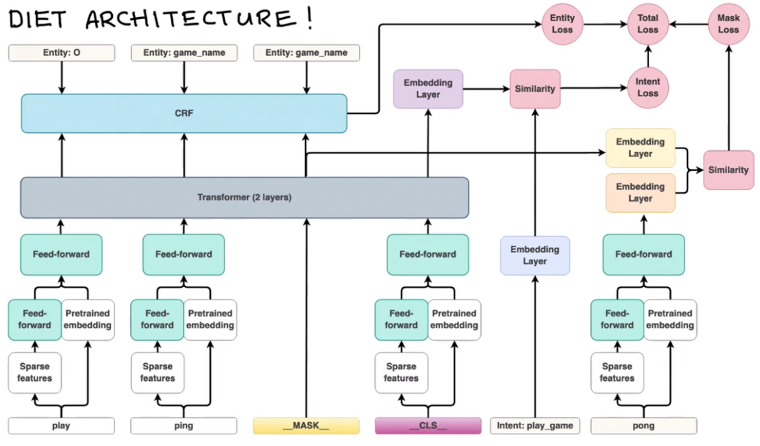

Instead of just relying on Dense Embeddings for sentences, RASA NLU tries to use Sparse / One-hot Encodings of words as part of a larger scheme of deriving the best possible embeddings for Conversational Understanding, in order to derive the intents and entities. It is a LEGO-style architecture, where one can swap out various parts of the model with other equivalent blocks. 

As an example, for getting the Pretrained Embeddings, one could easily swap out Word2vec for BERT, and for the Sparse Embeddings, one could easily use TF-IDF in place of Bag-of-Words.

While such models may be too complex for all but industry-grade NLP solutions, it is worth remembering the Law of Diminishing Returns in building AI products - achieving a 10% reduction in error often requires a significant jump in complexity, and that is where the cutting-edge of the industry often functions.